# Rhino for BogoVirus \\(\beta\\)

## Install dependencies

Run this block unless you run into this error: "InvalidConfigurationError: You haven't configured the CLI yet! Please configure by entering `/databricks/python_shell/scripts/db_ipykernel_launcher.py configure`"

In [0]:
pip install databricks-cli --upgrade

If you have just turned on the cluster or attached it to this notebook run the block below. The interpreter then will be restrated automatically and the libraries will remain in cluster while it is not detached/terminated. This block takes a few minutes:

In [0]:
%sh
sudo apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
pip install pygraphviz
pip install git+https://github.com/microsoft/causica
pip install networkx
pip install pyro-ppl
pip install pyvis

## Import packages

[Causica package](https://github.com/microsoft/causica) is currently under development and the "temporal version", a.k.a Rhino, which we are using in this repo is not ready through the package. Therefore, we downloaded the previous version via [this link](https://github.com/microsoft/causica/releases/tag/v0.0.0), unzipped and uploaded it on Databricks Repo. We named the repo causica_pkg to prevent confusion with the current version. 

**Note** that current causica version is installed on the above block; this helps installation of the causica dependencies. Even though we do not use the new version of the package, the dependencies are still consistent with the old version.

In [0]:
# this is where we cloned the causica_pkg package.
import sys
# update <user_id> to your DB user_id/email
sys.path.append("/Workspace/Repos/<user_id>")

# Some imports to get us started
import warnings
# warnings.filterwarnings("ignore")
import os
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Utilities
import os
import pandas as pd
import numpy as np
from datetime import datetime

# Plots
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# device: change cuda to cpu if GPU is not available; we recommend gpu training
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
# Rhino packages
# from causica_pkg.causica.experiment.steps.step_func import load_data
from causica_pkg.causica.datasets.variables import Variables
from causica_pkg.causica.datasets.dataset import TemporalDataset
from causica_pkg.causica.datasets.dataset import TemporalDataset
from causica_pkg.causica.datasets.temporal_causal_csv_dataset_loader import TemporalCausalCSVDatasetLoader

from causica_pkg.causica.models.deci.rhino import Rhino

## Data Preparation
We read the data from BogoVirus with random dose policy. We then convert the data in a format containing information of prev. and cur. days. Patients are sampled into train-test files. All the records of the the patients in trainset is used to train DECI model. The test set is used for validation of ATE estimations, which is not covered in this notebook.

The dataset is simulated before and here we only load it from SQL:

In [0]:
## move these to the top for visibility and easier change for your experiment ##


# update <path_to_save_graph_html> to the path you want to store html graph; it looks like: "<dir_path>/<filename>.html"
discovered_graph_path_tosave="<path_to_save_graph_html>"

# columns that will be passed to Causica -- excluding outcome may help with a better discovery 
selected_columns=["patient_id", "infection", "severity", "drug", "cum_drug", "efficacy"] #, "outcome"]

In [0]:
%sql
use bogovirus_beta;
-- select count(*) from cnt_100_patients -- 1385
-- select count(*) from observational_data -- 1052552
-- select count(*) from bogovirus_beta.xtst_0_of_10 -- 139886

A) Bob's dataset: Using dataset from one table in database:

In [0]:
# df = spark.sql("select * from observational_data").toPandas()

B) JM dataset: Using dataset from 10 bogovirus_beta.xtst_{}_of_10 tables:

In [0]:
df = spark.sql("select * from bogovirus_beta.xtst_0_of_10").toPandas()
df["patient_id"]=(df["patient_id"].astype(int)).astype(str)
last_pid = max(df['patient_id'].astype(int))

for idx in range(1,10):
  df_idx = spark.sql(
    "select * from bogovirus_beta.xtst_{}_of_10".format(str(idx))
  ).toPandas()
  df_idx["patient_id"]=(last_pid+df_idx["patient_id"].astype(int)).astype(str)
  df = pd.concat([df, df_idx], ignore_index=True, sort=False)
  last_pid=max(df['patient_id'].astype(int))

In [0]:
df.display()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:626: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


patient_id,cohort,day_number,infection,severity,drug,cum_drug,efficacy,outcome,reward,run
0,0,1,36,34.02369430362324,0.7,0.20738516166119414,8.319605084162296,0,-1,0
0,0,2,36,32.01107726627808,0.7,0.34804813542536656,8.248310285331897,0,-1,0
0,0,3,42,31.104351387902796,0.4,0.3638105019086861,3.8732549193478034,0,-1,0
0,0,4,47,35.06250861260204,0.6,0.43632439318978017,5.66896532485836,0,-1,0
0,0,5,54,38.991059479472796,0.0,0.3129909291079791,0.01596370937668094,0,-1,0
0,0,6,59,47.10012923101329,0.0,0.2227285335886055,-1.2091982703434327,0,-1,0
0,0,7,68,58.55192768663257,0.7,0.36055176074092266,7.941130836987874,0,-1,0
0,0,8,68,63.19662336356356,0.4,0.37288811745426065,5.149704575133867,0,-1,0
0,0,9,73,72.15666616080702,0.9,0.5301566778797034,7.705104604223226,0,-1,0
0,0,10,76,77.77017861030087,0.6,0.5510942467619684,4.303022231991778,0,-1,0


If outcome is not -1,0,1 this part converts them into that format, and doesn't change if the format is already correct:

In [0]:
# convert to {'die', 'recover', 'stay'}
df["outcome"]=df["outcome"].fillna("stay").replace({"none":"stay"})
set(df["outcome"])

Out[160]: {-1, 0, 1}

In [0]:
# convert to {-1, 0, 1}
df["outcome"] = df["outcome"].replace({"stay":0, "recover":1, "die":-1})
set(df["outcome"])

Out[161]: {-1, 0, 1}

### Split data
Split patients into train, val, test: 0.7, 0.2, 0.1 ratio:

In [0]:
import random
# ratio
train_ratio=0.7
val_ratio=0.2

# set size
all_patients = list(set(df["patient_id"]))
train_split=len(all_patients)*train_ratio
val_split=train_split+len(all_patients)*val_ratio

# shuffle
random.seed(242)
random.shuffle(all_patients)

# convert list to dataframe so we can use join later
all_patients = pd.DataFrame({"patient_id": all_patients})
print(all_patients.head(3))

  patient_id
0         85
1         14
2          9


In [0]:
# split patients
train_patients = all_patients.loc[:train_split,].reset_index(drop=True)
val_patients = all_patients.loc[train_split:val_split,].reset_index(drop=True)
test_patients = all_patients.loc[val_split:].reset_index(drop=True)

print("Number of patients:")
print("train:", train_patients.shape)
print("validation:", val_patients.shape)
print("test:", test_patients.shape)

Number of patients:
train: (64, 1)
validation: (18, 1)
test: (9, 1)


In [0]:
train_patients.head(3)

,patient_id
0,85
1,14
2,9


This is how we keep patients randomized but the day_numbers sorted:

In [0]:
sort_by_columns=["patient_id", "day_number"]
df_sorted=df.sort_values(by=sort_by_columns)

In [0]:
train_patients.merge(df_sorted, how="left", on="patient_id")

,patient_id,cohort,day_number,infection,severity,drug,cum_drug,efficacy,outcome,reward,run
0,85,4,1,29,14.291925,0.2,0.059450,2.013743,0,-1,9
1,85,4,2,34,15.925181,0.3,0.131943,4.192641,0,-1,9
2,85,4,3,41,15.540843,0.2,0.152315,2.052257,0,-1,9
3,85,4,4,42,19.108021,0.2,0.166078,1.908191,0,-1,9
4,85,4,5,43,23.723047,0.2,0.175856,2.333614,0,-1,9
...,...,...,...,...,...,...,...,...,...,...,...
973,46,1,10,62,69.081505,0.7,0.722213,1.459933,0,-1,5
974,46,1,11,68,79.469387,0.3,0.590964,1.675456,0,-1,5
975,46,1,12,71,92.922162,0.8,0.653390,3.439182,0,-1,5
976,46,1,13,77,106.369425,1.0,0.753606,2.226861,0,-1,5


We are dropping outcome for now, to focus mainly on causal discovery capability of causica:

In [0]:
sort_by_columns=["patient_id", "day_number"]
df_sorted=df.sort_values(by=sort_by_columns)
# selected_columns=["patient_id", "infection", "severity", "drug", "cum_drug", "efficacy", "outcome"]
train_df = train_patients.merge(df_sorted, how="left", on="patient_id").loc[:, selected_columns].reset_index(drop=True)
val_df = val_patients.merge(df_sorted, how="left", on="patient_id").loc[:, selected_columns].reset_index(drop=True)
test_df = test_patients.merge(df_sorted, how="left", on="patient_id").loc[:, selected_columns].reset_index(drop=True)
train_df.head()

,patient_id,infection,severity,drug,cum_drug,efficacy
0,85,29,14.291925,0.2,0.059450,2.013743
1,85,34,15.925181,0.3,0.131943,4.192641
2,85,41,15.540843,0.2,0.152315,2.052257
3,85,42,19.108021,0.2,0.166078,1.908191
4,85,43,23.723047,0.2,0.175856,2.333614


In [0]:
val_df.tail()

,patient_id,infection,severity,drug,cum_drug,efficacy
266,61,77,77.566428,0.7,0.728890,2.228775
267,61,84,90.855602,1.0,0.805234,1.277370
268,61,86,108.003502,1.6,1.040991,0.217373
269,61,95,128.395759,0.7,0.938054,0.410372
270,61,100,150.898876,0.1,0.696716,0.473783


### Create variables

In [0]:
# Method for creating variables.json
def create_variables(df, categorical_vars={}, timeseries_column_index=0, variables_json_path=None, text_vars=None, target_column_names=[]):
    if text_vars is None:
        text_vars = []
    variables_info = []

    for ident, column_name in enumerate(df.columns):
        # if ident == timeseries_column_index:
        # continue
        query = column_name if target_column_names is not None else ident != len(df.columns) - 1
        var = {
            "id": ident,
            "query": query,
            "name": column_name,
        }
        if column_name not in text_vars:
            var["type"] = "categorical" if column_name in categorical_vars else "continuous"
            var["lower"] = 0 if column_name in categorical_vars else np.nanmin(df[column_name])
            var["upper"] = (
                categorical_vars[column_name] - 1 if column_name in categorical_vars else np.nanmax(df[column_name])
            )
        elif column_name in text_vars:
            var["type"] = "text"
            var["overwrite_processed_dim"] = 768  # Sentence Transformer model has that dimension

        if column_name in target_column_names:
            var["group_name"]="targets"
        variables_info.append(var)

    variable_dict = {"variables": variables_info, "metadata_variables": []}
    del variable_dict["variables"][timeseries_column_index]
    variables = Variables.create_from_dict(variable_dict)
    if variables_json_path:
        variables.save(variables_json_path)
    return variables

def remove_series_index_and_generate_segmentation(
    data: np.ndarray, mask: np.ndarray, timeseries_column_index: int
  ): # -> Tuple[np.ndarray, np.ndarray, List[Tuple[int, int]]]:
    """
    #     This removes the column of the data where we store the time-series index.
    #     It also generates the corresponding index segmentations list.
    #     NOTE: This assumes that the series indices are contiguous.
    #     Args:
    #         data: Temporal data.
    #         mask: the corresponding masks of the data
    #         timeseries_column_index: the column index specifying the time series number
    #     """
    start_idx = 0
    cur_series_number = data[0, timeseries_column_index]
    series_seg = []

    for _pointer in range(data.shape[0]):
        _pointer_series = data[_pointer, timeseries_column_index]
        if _pointer_series == cur_series_number:
          continue
        # we are on the new series
        series_seg.append((start_idx, _pointer - 1))
        cur_series_number = _pointer_series
        start_idx = _pointer
    
    # last segment
    if start_idx < (data.shape[0]-1):
        series_seg.append(
          (start_idx, data.shape[0]-1)
        )
    proc_data = np.delete(data, timeseries_column_index, 1)
    proc_mask = np.delete(mask, timeseries_column_index, 1)
    return proc_data, proc_mask, series_seg



In [0]:
# note that the lower/upper bound of train data should be representative of future data
variables = create_variables(train_df, categorical_vars={}, timeseries_column_index=0)

In [0]:
len(variables)

Out[171]: 5

### Create Dataset object

In [0]:
# Set up data in a suitable form for DECI/Rhino to consume, using the loaded data types
def get_mask_and_numpy(_df):
    # create mask => 0 for missed values, 1 for the rest
    mask_data = np.ones_like(_df)
    mask_data[_df.isna()]=0
    # na to zero
    _df=_df.fillna(0)
    numpy_data = _df.to_numpy()
    return numpy_data, mask_data

train_np, train_mask = get_mask_and_numpy(train_df)
val_np, val_mask = get_mask_and_numpy(val_df)
test_np, test_mask = get_mask_and_numpy(test_df)

Segmentation takes a while (the function needs optimization)

In [0]:
# let's take all train, val, test the same for now
tr_proc_data, tr_proc_mask, tr_series_seg = remove_series_index_and_generate_segmentation(train_np, train_mask, timeseries_column_index=0)
val_proc_data, val_proc_mask, val_series_seg = remove_series_index_and_generate_segmentation(val_np, val_mask, timeseries_column_index=0)
test_proc_data, test_proc_mask, test_series_seg = remove_series_index_and_generate_segmentation(test_np, test_mask, timeseries_column_index=0)

In [0]:
# check the first segment
print(tr_series_seg[0])
train_df.head(17)

(0, 18)


,patient_id,infection,severity,drug,cum_drug,efficacy
0,85,29,14.291925,0.2,0.059450,2.013743
1,85,34,15.925181,0.3,0.131943,4.192641
2,85,41,15.540843,0.2,0.152315,2.052257
3,85,42,19.108021,0.2,0.166078,1.908191
4,85,43,23.723047,0.2,0.175856,2.333614
5,85,45,28.851562,0.6,0.301851,6.641329
6,85,49,28.487122,0.4,0.329682,4.570757
7,85,50,31.468856,0.3,0.320876,3.459803
8,85,56,35.990590,0.1,0.253189,1.274035
9,85,64,42.692443,0.5,0.328947,5.586580


In [0]:
# check the last segment
last_segment=tr_series_seg[-1]
print(last_segment)
# check one element before to make sure the top item belongs to the previous segment
train_df.loc[last_segment[0]-1:]


(964, 977)


,patient_id,infection,severity,drug,cum_drug,efficacy
963,44,82,134.514883,0.3,0.581270,1.633163
964,46,28,19.070006,0.1,0.029622,0.919293
965,46,37,22.097649,0.2,0.079046,2.751426
966,46,46,26.171516,0.1,0.085259,1.032267
967,46,46,32.694225,0.2,0.121796,2.530004
968,46,47,37.006305,0.1,0.115310,0.826355
969,46,49,44.354849,0.1,0.110645,0.812059
970,46,54,53.037404,0.4,0.198469,4.297234
971,46,58,59.045944,1.3,0.540588,10.082840
972,46,62,60.216040,1.2,0.731416,3.286501


In [0]:
# check if we see the same numbers
tr_proc_data[last_segment[0]-1:last_segment[0]+1,]

Out[176]: array([[82, 134.51488253904796, 0.3, 0.5812700117931426,
        1.6331627350376732],
       [28, 19.070005833423867, 0.1, 0.029621523257220672,
        0.9192927341961212]], dtype=object)

In [0]:
# check if we see the same numbers
tr_proc_mask[last_segment[0]-1:last_segment[0]+1,]

Out[177]: array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=object)

### Create Dataset object

In [0]:
# variables = create_variables(df_rhino, categorical_vars={"outcome":3}, timeseries_column_index=0)
train_dataset = TemporalDataset(
    train_data=tr_proc_data,
    train_mask=tr_proc_mask,
    transition_matrix=None,
    adjacency_data=None,
    intervention_data=None,
    counterfactual_data=None,
    val_data=val_proc_data,
    val_mask=val_proc_mask,
    test_data=test_proc_data,
    test_mask= test_proc_mask,
    variables=variables,
    # data_split=data_split,
    train_segmentation=tr_series_seg,
    test_segmentation=test_series_seg,
    val_segmentation=val_series_seg,
)

In [0]:
len(variables)

Out[179]: 5

## Part 1: Graph Discovery

The following snippets step through the process of:
 - configuring and creating a DECI model
 - training a model with no graph constraints
 - training a model with graph constraints
 
*Note*: if you have already trained a DECI model, you can reload the model by skipping to the section below on "Loading a saved DECI model"

In [0]:
# we create a directory to save the results of all the experiments
outputs_root = "runs/"
os.makedirs(outputs_root, exist_ok=True)

<!-- ### Train with No Constraint -->

### Setup Causica configuration

Causica models have a number of hyperparameters, but attention need not be paid to all of them. Here we highlight key hyperparameters that might be changed to improve performance. Note that the first parts are the Rhino specific hyperparameters, and the second one is common between Rhino and other Causica models such as DECI:

**Rhino Specific** 
 - `lag` The lag for the AR-DECI model. It controls the number of temporal backward step to check for causal relation. E.g., if lag=1, the dynamic of values between t-1 and t will be investigated. If lag=0, it will be a non-temporal DECI model. 
 - `allow_instantaneous` Whether to allow the instantaneous effects. If `False` it will not look for causal relationship within one time-step, and only on the temporal aspect. Otherwise, it will look across features within one timestep, too.
 - `ICGNN_embedding_size`: This is the embedding sizes for ICGNN.
 - `init_logits`: The initialized logits used for temporal variational distribution. For each pair of nodes x_i and x_j where i < j, we sample a three way categorical C_ij. If C_ij = 0, we sample the edge x_i -> x_j, if C_ij = 1, we sample the edge x_j -> x_i, and if C_ij = 2, there is no edge between these nodes. This variational distribution is faster to use than ENCO because it avoids any calls to `torch.stack`.

 - `conditional_embedding_size`: the embedding size of hypernet of conditional spline flow.
 - `conditional_encoder_layer_sizes`: hypernet encoder layer size
 - `conditional_decoder_layer_sizes`: hypernet decoder layer size
 - `conditional_spline_order`: the transformation order used for conditional spline flow
 - `additional_spline_flow`: the number of additional spline flow on top of conditional spline flow.

**General Causica** 
 - `learning_rate` is the step size for the Adam optimizer. Decrease the learning rate if training is unstable
 - `var_dist_A_learning_rate` is the learning rate for the causal graph distribution
 - `standardize_data_mean` and `standardize_data_std` tell DECI to standarize the data by subtracting the mean and dividing by the standard deviation of each column. *Note*: this improves training, but you need to take care because treatment effects will now be computed in this standardized space
 - `max_auglag_inner_epochs` is the number of gradient steps taken in each "inner step" of the DECI optimization. Decrease this to speed up training (at the risk of training not converging). Increase this to learn a more accurate model, or when the dataset is larger.
 - `max_steps_auglag` is the maximum number of "inner steps" taken. Decrease this to end training early (e.g. before a DAG has been found) to speed up training
 - `base_distribution_type` is the type of DECI model that is trained. It should be either `gaussian` or `spline`. Use `spline` for highly non-Gaussian data, or to fit a better density model of the observational data.
 - `lambda_sparse` controls the coefficient of graph sparsity regularizer. 

Other hyperparameters are less frequently changed.

To speed up training you can try the followings:
 - increasing `learning_rate`
 - increasing `batch_size` (reduces noise when using higher learning rate)
 - decreasing `max_steps_auglag` (go as low as you can and still get a DAG)
 - decreasing `max_auglag_inner_epochs`

Note that an undertrained model might be unsuccessful to converge to a DAG or may have less accurate predictions.

In [0]:
# DECI configurations
model_hyperparams={
  "ICGNN_embedding_size": None,
  "additional_spline_flow": 0,
  "allow_instantaneous": True,
  "base_distribution_type": "gaussian",
  "cate_rff_lengthscale": [
    0.1,
    1
  ],
  "cate_rff_n_features": 3000,
  "conditional_decoder_layer_sizes": [
    10
  ],
  "conditional_embedding_size": 16,
  "conditional_encoder_layer_sizes": [
    10
  ],
  "conditional_spline_order": "linear",
  "decoder_layer_sizes": [
    10
  ],
  "encoder_layer_sizes": [
    10
  ],
  "imputation": False,
  "init_logits": [
    +3,
    +3
  ],
  "lag": 1,
  "lambda_dag": 10,
  "lambda_prior": 100000,
  "lambda_sparse": 50, #15,
  "norm_layers": True,
  "prior_A_confidence": 0.5,
  "random_seed": 0,
  "res_connection": True,
  "spline_bins": 8,
  "tau_gumbel": 0.25,
  "var_dist_A_mode": "temporal_three"
}
training_hyperparams={
    "learning_rate": 0.001, # 0.001,
    "likelihoods_learning_rate": 0.001,
    "batch_size": 64,
    "stardardize_data_mean": True,
    "stardardize_data_std": True,
    "rho": 1.0,
    "safety_rho": 1e16, #10000000000000.0,
    "alpha": 0.0,
    "safety_alpha": 1e16, #10000000000000.0
    "tol_dag": -1,
    "progress_rate": 0.65,
    "max_steps_auglag": 200, #it gets nan after 45 steps
    "max_auglag_inner_epochs": 6000, #2000,
    "max_p_train_dropout": 0,
    "reconstruction_loss_factor": 1.0,
    "anneal_entropy": "noanneal"
}

In [0]:
train_dataset.train_data_and_mask[1].shape

Out[182]: (978, 5)

In [0]:
train_dataset.train_data_and_mask[0].shape

Out[183]: (978, 5)

In [0]:
# compare the variable standard-deviations -- causal discovery model have a biased toward features with higher stds
for var, idx in variables.name_to_idx.items():
  print(var, np.array(train_dataset.train_data_and_mask[0][:,idx]).std())

infection 19.915520562512235
severity 33.30185602239567
drug 0.6370220041092232
cum_drug 0.37529179741749236
efficacy 2.796287074743943


### Train or Load Model

In [0]:
model_id = f"bogo_{datetime.now():%Y_%m_%d_%H%M%S}"
model = Rhino.create(model_id, save_dir=os.path.join(outputs_root, model_id), variables=variables, model_config_dict=model_hyperparams, device=device)
# model.set_graph_constraint(constraint_matrix)
model.run_train(train_dataset, training_hyperparams)

/Workspace/Repos/matavako@microsoft.com/causica_pkg/causica/preprocessing/data_processor.py:415: UserWarning: Data too high for continous variables [1 3]
  warnings.warn(
/Workspace/Repos/matavako@microsoft.com/causica_pkg/causica/preprocessing/data_processor.py:415: UserWarning: Data too high for continous variables [3]
  warnings.warn(
Saving logs to runs/bogo_2023_04_19_225612/train_output/summary
Auglag Step: 0
Beta Value: 1.0
LR: 0.001
Inner Step: 100, loss: 4304.37, log p(x|A): -4304.26, dag: 0.00000000, log p(A)_sp: -0.12, log q(A): -0.009, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 9.45e+03, cts_medse_icgnn: 6.92e+03
Inner Step: 200, loss: 3340.92, log p(x|A): -3340.81, dag: 0.00000000, log p(A)_sp: -0.12, log q(A): -0.010, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 8.77e+03, cts_medse_icgnn: 6.35e+03
Inner Step: 300, loss: 2705.47, log p(x|A): -2705.36, dag: 0.00504174, log p(A)_sp: -0.12, log q(A): -0.010, H filled: 0.000, rec

In [0]:
print("Saved as ", model_id)

Saved as  bogo_2023_04_19_225612


If you have a previously trained model, you can use _load_ function and have the path-to-saved-model as input to load it:

In [0]:
# model_id="bogo_2023_04_19_225612"
# model = Rhino.load(model_id, os.path.join(outputs_root, model_id), device=device)

In [0]:
model

Out[188]: Rhino(
  (ICGNN): TemporalContractiveInvertibleGNN(
    (f): TemporalFGNNI(
      (g): Sequential(
        (0): resBlock(
          (block): Sequential(
            (0): Linear(in_features=10, out_features=10, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
          )
        )
        (1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (2): Linear(in_features=10, out_features=5, bias=True)
        (3): Identity()
      )
      (f): Sequential(
        (0): resBlock(
          (block): Sequential(
            (0): Linear(in_features=10, out_features=10, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
          )
        )
        (1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (2): Linear(in_features=10, out_features=5, bias=True)
        (3): Identity()
      )
    )
  )
  (likelihoods): ModuleDict(
    (continuous): GaussianBase()
  )
  (var_dist_A): TemporalThreeWayGrahpDist()
)

### Retrieve Adjacency Matrix

Causica discovers a distribution of graphs. In order to convert this knowledge into a probablistic representation of edge existance, we sample the model 10000 times here and take the average of the adjacency matrices. 

To plot or evaluate the discovered graph, we select a threshold for converting the probablities into 0 and 1.

**Note** The shape of adjacency matrix is [samples, lag+1, num_nodes, num_nodes]:
- adj_matrix[s,0,:,:] represent instantaneous connections within one timestep for sample s
- adj_matrix[s,1,:,:] represents causal impact of previous timestep (t-1) on the current timestep (t) for sample s
- adj_matrix[s,2,:,:] represents causal impact of previous time-step (t-2)on the current timestep (t) for sample s

and so on. Therefore, if the lag=1, only we discovered potential causal within one day and from yesterday to today.

In [0]:
adj_mat = model.get_adj_matrix(
            samples=10000, most_likely_graph=False, squeeze=True
        )  # shape [samples, lag+1, num_nodes, num_nodes]
        # Convert to static graph

We use a util function to convert the above format to [samples, ((lag+1)*num_nodes), ((lag+1)*num_nodes)] for plotting purpose. This representation is less efficient (E.g., (2x6x6) vs. (2+6)x(2+6)), but closer to the non-temporal causal representation, and thus more understandable and easier for plot-functions. It represents causal connections between all nodes within the lagged distance together.

In [0]:
from causica_pkg.causica.utils.nri_utils import convert_temporal_to_static_adjacency_matrix

static_adj_mat = convert_temporal_to_static_adjacency_matrix(adj_mat, conversion_type="full_time", fill_value=0)

static_adj_mat = static_adj_mat.mean(axis=0)
static_adj_mat.shape

Out[190]: (10, 10)

In [0]:
static_adj_mat

Out[191]: array([[0.    , 0.0024, 0.0019, 0.0044, 0.0054, 0.0037, 0.0035, 0.0023,
        0.002 , 0.0024],
       [0.9702, 0.    , 0.0052, 0.0142, 0.0076, 0.0037, 0.0022, 0.003 ,
        0.0028, 0.0024],
       [0.016 , 0.0359, 0.    , 0.87  , 0.9827, 0.0033, 0.0074, 0.0035,
        0.0061, 0.0037],
       [0.0627, 0.3625, 0.1042, 0.    , 0.015 , 0.8527, 0.9926, 0.9926,
        0.9967, 0.9972],
       [0.0148, 0.0257, 0.0025, 0.0088, 0.    , 0.0034, 0.981 , 0.0671,
        0.0055, 0.0016],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0024, 0.0019,
        0.0044, 0.0054],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.9702, 0.    , 0.0052,
        0.0142, 0.0076],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.016 , 0.0359, 0.    ,
        0.87  , 0.9827],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0627, 0.3625, 0.1042,
        0.    , 0.015 ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0148, 0.0257, 0.0025,
        0.0088, 0.    ]])

Thresholds are one of the knobs for the trade-off between precision & recall:

In [0]:
# selecting a probability threshold for an edge
(static_adj_mat>0.8).sum()

Out[192]: 12

### Plot the Discovered Graph

#### Setup labels & colors

Mapping between the variables and their indices:

In [0]:
varindex_to_name = {i: var.name for (i, var) in enumerate(variables)}
varname_to_index = {var.name:i for (i, var) in enumerate(variables)}

In [0]:
varindex_to_name

Out[194]: {0: 'infection', 1: 'severity', 2: 'drug', 3: 'cum_drug', 4: 'efficacy'}

The adj matrix will have the shape (lag+1, num_nodes, num_nodes), where adj_sample[0,...] is the instantaneous adj_matrix & adj_sample[1:,...] shows the lagged relations.

In [0]:
# node colors
color_map={
  "infection":"#DBDBDB",
  "severity":"#FFC000",
  "drug":"#BDD7EE",
  "cum_drug":"#FFFF00",
  "efficacy":"#C5E0B4",
  "outcome":"#FF0000"
}

# numbers grow: top-to-bottom, left-to-right
xposition_map={
  "infection":-225, 
  "severity":-250,
  "drug":-175, 
  "cum_drug":-200, 
  "efficacy":-150, 
  "outcome":-300
}

yposition_map={
  "infection":-250,
  "severity":200,
  "drug": -50,
  "cum_drug":-150,
  "efficacy":50,
  "outcome":125
}

# timestamp labels
temporal_prefix = {0:"prev_",1:""}

Mapping between the variables and their indices on the Causica discovered matrix graph:

In [0]:
varindex_to_name_temporal={}
varname_to_color_temporal={}
varname_to_xpos_temporal={}
varname_to_ypos_temporal={}

for tidx in range(len(temporal_prefix)):
  for varidx in range(len(varindex_to_name)):
    # get variable name
    varname=varindex_to_name[varidx]
    # add temporal prefix
    temp_index=tidx*len(varindex_to_name)+varidx
    temp_name=temporal_prefix[tidx]+varname
    varindex_to_name_temporal[temp_index]=temp_name
    # add color info
    varname_to_color_temporal[temp_name]=color_map[varname]
    # add position info
    varname_to_xpos_temporal[temp_name]=xposition_map[varname] * ((-1) ** tidx) #+ (temporal_xpos_add * tidx)
    varname_to_ypos_temporal[temp_name]=yposition_map[varname] 

In [0]:
varindex_to_name_temporal.keys()

Out[197]: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
model.get_adj_matrix().shape

Out[198]: (100, 2, 5, 5)

#### Plot using Networkx

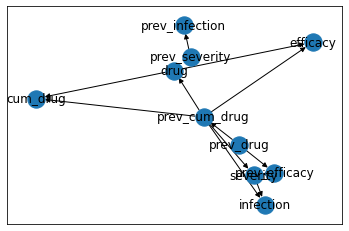

In [0]:
pred_graph = nx.from_numpy_array(static_adj_mat>0.8, create_using=nx.DiGraph)
pred_graph = nx.relabel_nodes(pred_graph, varindex_to_name_temporal)
nx.draw_networkx(pred_graph, arrows=True, with_labels=True)

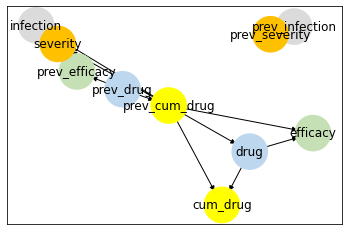

In [0]:
# color graph
color_graph = [varname_to_color_temporal[node] for node in pred_graph]

nx.draw_networkx(pred_graph, node_color=color_graph, linewidths=5, node_size=1000, node_shape="o", arrows=True, with_labels=True)

#### Plot using pyvis

Using pyvis, we create an html export of the discovered graph:

In [0]:
# check the path to save html file
discovered_graph_path_tosave

Out[201]: '/Workspace/Users/matavako@microsoft.com/JM_bogo_rhino_without_outcome.html'

In [0]:
import networkx as nx
from pyvis.network import Network

def create_html_networkx_plot(nx_object, filename, varname_to_color=None, varname_to_xpos=None, varname_to_ypos=None):
    # create a pyvis network object
    pyvis_network = Network('600px', '600px',directed=True)
    pyvis_network.from_nx(pred_graph)

    if varname_to_color:
      for node in pyvis_network.nodes:
        node['shape']='ellipse'
        node['size']=13
        if varname_to_color:
          node['color']=varname_to_color[node['id']]
        if varname_to_xpos and varname_to_ypos:
          node['x']=varname_to_xpos[node['id']]
          node['y']=varname_to_ypos[node['id']]
          # print(node)    
    # set the node positions
    if varname_to_xpos and varname_to_ypos:
      # create a separator for the timesteps
      pyvis_network.add_node('w_u', label="", color="#000000", size=1, shape='dot', x=0, y=min(varname_to_ypos.values())-20)
      pyvis_network.add_node('w_d', label="", color="#000000", size=1, shape='dot', x=0, y=max(varname_to_ypos.values())+20)
      pyvis_network.add_edge('w_u','w_d')
      pyvis_network.add_edge('w_d','w_u')
      # keep the positions fixed
      pyvis_network.toggle_physics(False) 
    else:
      pyvis_network.show_buttons(filter_=['physics'])

    # save the pyvis network object as an HTML file
    pyvis_network.write_html(filename)

    # print a message indicating that the HTML file has been created
    print(f"HTML file {filename} has been created.")

In [0]:
# create an HTML file to plot the NetworkX object using Node.js
create_html_networkx_plot(pred_graph, discovered_graph_path_tosave, varname_to_color_temporal, varname_to_xpos_temporal, varname_to_ypos_temporal)

HTML file /Workspace/Users/matavako@microsoft.com/JM_bogo_rhino_without_outcome.html has been created.
